# Imports

In [1]:
import sys
import copy
import numpy as np
from model.base import CovidModel, SimulationParameters, set_parameters, normal_ci
from utils import BasicStatistics, AddPolicy, RemovePolicy, Propaganda, setup_city_layout, AddPolicyInfectedRate, confidence_interval, multiple_runs
from model.utils import SocialPolicy
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import timedelta

In [2]:
#sys.path.insert(0, '../..')

## Real Data

Checking file names

In [3]:
os.listdir(os.getcwd()+'/data')

['.~lock.Metrics by Date of Death by County.csv#',
 'Metrics by Date of Death by County.csv',
 'MetricsbyCounty.csv',
 'Metrics by Test Date by County.csv',
 'MetricsbyReportDate.csv',
 'us-counties.csv']

### First dataframe

In [4]:
df = pd.read_csv('./data/MetricsbyCounty.csv')

greene_df = df.loc[df.County == 'GREENE']
greene_df

,County,Nomes de medida,7-Day Range End Date,7-Day Range Start Date,Dashboard Update Date,Most Recent Test Date,Valores de medida
342,GREENE,Population,15/02/2021,09/02/2021,18/02/2021,17/02/2021,293.086
343,GREENE,Confirmed Cases,15/02/2021,09/02/2021,18/02/2021,17/02/2021,23.138
344,GREENE,Confirmed Deaths,15/02/2021,09/02/2021,18/02/2021,17/02/2021,414
345,GREENE,PCR Tests,15/02/2021,09/02/2021,18/02/2021,17/02/2021,211.347
346,GREENE,7-Day Confirmed Cases,15/02/2021,09/02/2021,18/02/2021,17/02/2021,187
347,GREENE,7-Day Confirmed Deaths,15/02/2021,09/02/2021,18/02/2021,17/02/2021,4
348,GREENE,7-Day PCR Tests,15/02/2021,09/02/2021,18/02/2021,17/02/2021,3.304
349,GREENE,7-Day PCR Positivity Rate,15/02/2021,09/02/2021,18/02/2021,17/02/2021,"6,416464891"
350,GREENE,7-Day-Cases per 100k,15/02/2021,09/02/2021,18/02/2021,17/02/2021,"63,803798203"


Only a few rows.

### Second dataframe

In [5]:
df_deaths = pd.read_csv('./data/Metrics by Date of Death by County.csv', encoding = "utf-16le", sep='\t', header=1)
df_deaths.head()

,Dod,Date of Death,ADAIR,ANDREW,ATCHISON,AUDRAIN,BARRY,BARTON,BATES,BENTON,...,SULLIVAN,TANEY,TEXAS,VERNON,WARREN,WASHINGTON,WAYNE,WEBSTER,WORTH,WRIGHT
0,Total geral,Total,16.0,17.0,6.0,57.0,44.0,12.0,22.0,25.0,...,13.0,82.0,22.0,36.0,17.0,45.0,10.0,49.0,1.0,27.0
1,16/02/2021,16/02/2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,15/02/2021,15/02/2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14/02/2021,14/02/2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,13/02/2021,13/02/2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
print(df_deaths['Date of Death'][320:350])

320    03/04/2020
321    02/04/2020
322    01/04/2020
323    31/03/2020
324    30/03/2020
325    29/03/2020
326    28/03/2020
327    27/03/2020
328    26/03/2020
329    25/03/2020
330    24/03/2020
331    23/03/2020
332    22/03/2020
333    20/03/2020
334    18/03/2020
335    15/01/2020
336    13/01/2020
337    08/01/2020
338    07/01/2020
339    04/01/2020
340    03/01/2020
341    30/07/1976
342    06/08/1949
343    07/02/1942
344    16/04/1941
345    19/03/1939
346    30/10/1938
347    27/10/1937
348    05/01/1936
349    22/12/1935
Name: Date of Death, dtype: object


Selecting appropriate data

In [7]:
# Selecting columns
df_deaths = df_deaths[['Dod', 'Date of Death', 'GREENE']]

In [8]:
df_deaths.head()

,Dod,Date of Death,GREENE
0,Total geral,Total,414.0
1,16/02/2021,16/02/2021,NaN
2,15/02/2021,15/02/2021,NaN
3,14/02/2021,14/02/2021,NaN
4,13/02/2021,13/02/2021,1.0


In [9]:
df_deaths.dropna(inplace=True)

In [10]:
# Dropping redundant column
assert np.all(df_deaths.Dod.iloc[1:] == df_deaths['Date of Death'].iloc[1:])
df_deaths.drop(columns=['Dod'], inplace=True)
df_deaths.set_index('Date of Death', inplace=True)

In [11]:
df_deaths.head()

,GREENE
Date of Death,
Total,414.0
13/02/2021,1.0
11/02/2021,2.0
09/02/2021,1.0
08/02/2021,1.0


In [12]:
df_deaths.tail()

,GREENE
Date of Death,
27/03/2020,1.0
24/03/2020,2.0
23/03/2020,1.0
08/01/2020,1.0
07/02/1942,0.0


In [13]:
df_deaths.columns = ['Deaths']
df_deaths['Deaths'] = df_deaths['Deaths'].astype(int)

In [14]:
df_deaths.drop(index=['Total'], inplace=True)

In [15]:
df_deaths.index = pd.to_datetime(df_deaths.index)

In [16]:
df_deaths.tail()

,Deaths
Date of Death,
2020-03-27,1
2020-03-24,2
2020-03-23,1
2020-08-01,1
1942-07-02,0


In [17]:
print(df_deaths.shape)
# Removing weird ancient rows
df_deaths = df_deaths.loc[df_deaths.index > '01-01-2020']
print(df_deaths.shape)

(178, 1)
(177, 1)


<AxesSubplot:xlabel='Date of Death'>

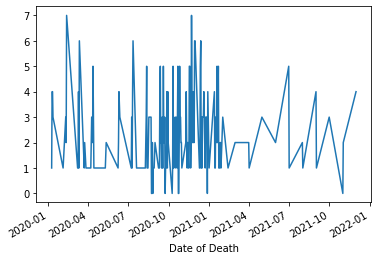

In [18]:
df_deaths
df_deaths.Deaths.plot()

In [19]:
df_deaths.head()

,Deaths
Date of Death,
2021-02-13,1
2021-11-02,2
2021-09-02,1
2021-08-02,1
2021-07-02,1


<AxesSubplot:xlabel='Date of Death'>

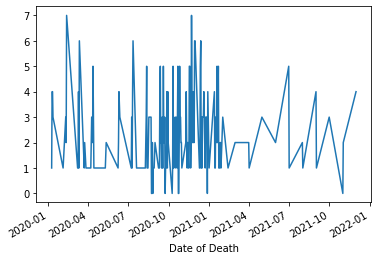

In [20]:
df_deaths
df_deaths.Deaths.plot()

In [21]:
df_deaths.Deaths.sum()

413

<AxesSubplot:xlabel='Date of Death'>

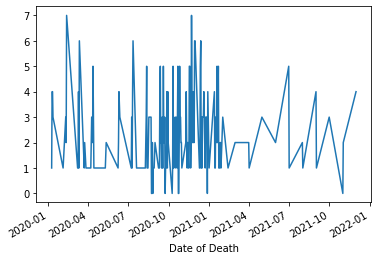

In [22]:
df_deaths.Deaths.plot()

### Third dataframe

In [23]:
df_tests = pd.read_csv('./data/Metrics by Test Date by County.csv', encoding = "utf-16le", sep='\t', header=1)
df_tests = df_tests[['Unnamed: 0', 'GREENE', 'GREENE.1', 'GREENE.2', 'GREENE.3']]
df_tests.head()
df_tests.columns = df_tests.iloc[0]
df_tests.drop(index=[0, 1], inplace=True)
df_tests.set_index('Test Date', inplace=True)
df_tests.replace({np.NaN: 0}, inplace=True)
df_tests.index = pd.to_datetime(df_tests.index)
#df_tests = df_tests.astype(int)
df_tests

,Confirmed Cases,PCR Tests,* Antigen Tests,Serology Tests
Test Date,,,,
2021-02-17,1,11,7,0
2021-02-16,20,200,114,2
2021-02-15,13,334,254,1
2021-02-14,15,234,207,0
2021-02-13,13,327,89,0
...,...,...,...,...
2020-05-03,0,0,0,0
2020-04-03,0,0,0,0
2020-03-03,0,1,0,0


In [24]:
df_tests['Confirmed Cases']

Test Date
2021-02-17     1
2021-02-16    20
2021-02-15    13
2021-02-14    15
2021-02-13    13
              ..
2020-05-03     0
2020-04-03     0
2020-03-03     0
2020-02-03     0
2020-01-03     0
Name: Confirmed Cases, Length: 354, dtype: object

In [25]:
merged_df = pd.merge(df_deaths, df_tests, left_index=True, right_index=True)
merged_df.drop(columns=['PCR Tests', '* Antigen Tests', 'Serology Tests'], inplace=True)
merged_df.head()

,Deaths,Confirmed Cases
2021-02-13,1,13
2021-11-02,2,37
2021-09-02,1,53
2021-08-02,1,75
2021-07-02,1,21


In [26]:
merged_df['Confirmed Cases'] = merged_df['Confirmed Cases'].astype(int)

In [27]:
merged_df['Cumulative Deaths'] = np.cumsum(merged_df['Deaths'])
merged_df['Cumulative Cases'] = np.cumsum(merged_df['Confirmed Cases'])
merged_df.head()

,Deaths,Confirmed Cases,Cumulative Deaths,Cumulative Cases
2021-02-13,1,13,1,13
2021-11-02,2,37,3,50
2021-09-02,1,53,4,103
2021-08-02,1,75,5,178
2021-07-02,1,21,6,199


<AxesSubplot:>

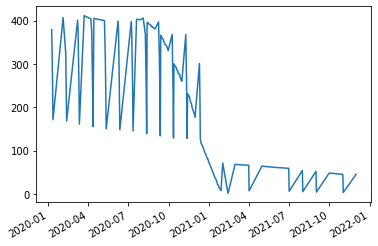

In [28]:
a = np.cumsum(merged_df['Deaths'])
a.plot()

### NYTimes Dataset

In [29]:
os.listdir('./data')

['.~lock.Metrics by Date of Death by County.csv#',
 'Metrics by Date of Death by County.csv',
 'MetricsbyCounty.csv',
 'Metrics by Test Date by County.csv',
 'MetricsbyReportDate.csv',
 'us-counties.csv']

In [30]:
us_counties = pd.read_csv("./data/us-counties.csv")

us_counties.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0
1,2020-01-22,Snohomish,Washington,53061.0,1,0.0
2,2020-01-23,Snohomish,Washington,53061.0,1,0.0
3,2020-01-24,Cook,Illinois,17031.0,1,0.0
4,2020-01-24,Snohomish,Washington,53061.0,1,0.0


In [31]:
us_counties = us_counties.loc[(us_counties.county == 'Greene') & (us_counties.state == 'Missouri')]
us_counties.index = pd.to_datetime(us_counties['date'])
assert sum(us_counties.fips == 29077.0) == us_counties.shape[0]
us_counties.drop(columns=['county', 'state', 'date', 'fips'], inplace=True)
us_counties.head()

,cases,deaths
date,,
2020-03-12,1,0.0
2020-03-13,1,0.0
2020-03-14,2,0.0
2020-03-15,2,0.0
2020-03-16,3,0.0


In [32]:
us_counties.tail()

,cases,deaths
date,,
2021-02-14,27048,403.0
2021-02-15,27048,403.0
2021-02-16,27157,403.0
2021-02-17,27202,404.0
2021-02-18,27226,414.0


<AxesSubplot:xlabel='date'>

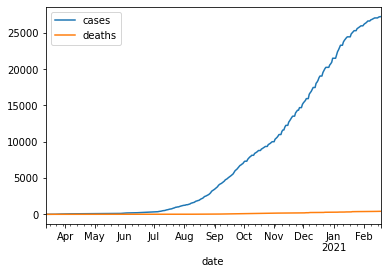

In [33]:
us_counties.plot()

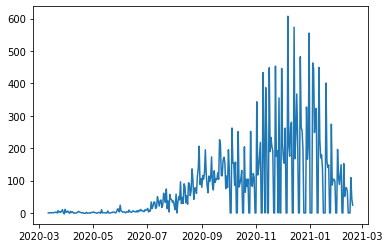

In [34]:
us_counties['daily_cases'] = np.concatenate(([0], us_counties.cases[1:].values - us_counties.cases[:-1].values))
plt.plot(us_counties.daily_cases)

In [35]:
us_counties['mean_daily_cases'] = us_counties['daily_cases'].rolling(7).mean()

<AxesSubplot:xlabel='date'>

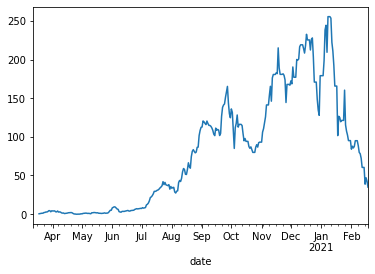

In [36]:
us_counties.mean_daily_cases.plot()

# Simulation

## Greene LockDown Parameters

In [37]:
start_date = us_counties.iloc[0]._name

Phase 0: mar 26 - may 3
   - Stay at home order (severe lockdown)
   - Private schools closed
   
Phase 1: may 4 - may 22
   - Either "max 25% occupancy" or "no more than 25 people allowed"
   - Private schools closed

Phase 2: may 23 - jun 14
   - Public gatherings from max 25 people to max 25% occupancy
   - Private schools closed

Phase 3: jun 15 - jul 15
   - Most occupancy limits went to 50%. Public gatherings remained at 25%.
   - Private schools may reopen (assumes public schools are reopened across the state in June)

Phase 3a: jul 16 - oct 11
   - Most occupancy limits went to 50%. Public gatherings remained at 25%.
   - Private schools open

Phase 3b: oct 12 - jan 9 2021
   - Most occupancy limits went to 50% (including public gatherings).
   - Private schools open


In [38]:
s = pd.to_datetime(
    pd.Series(['3/26/2020', 
               '5/4/2020', 
               '5/23/2020', 
               '6/15/2020', 
               '7/16/2020', 
               '10/12/2020', 
               #'1/10/2021'
              ]))

In [39]:
abs_dates = s - start_date
dates_df = pd.DataFrame(s)
dates_df['phase'] = ['0', '1', '2', '3', '3a','3b', 
                     #'4'
                    ]
dates_df['num_days'] = abs_dates.apply(lambda x: int(x.days))
dates_df.columns = ['date', 'phase', 'num_days']

In [40]:
dates_df

,date,phase,num_days
0,2020-03-26,0,14
1,2020-05-04,1,53
2,2020-05-23,2,72
3,2020-06-15,3,95
4,2020-07-16,3a,126
5,2020-10-12,3b,214


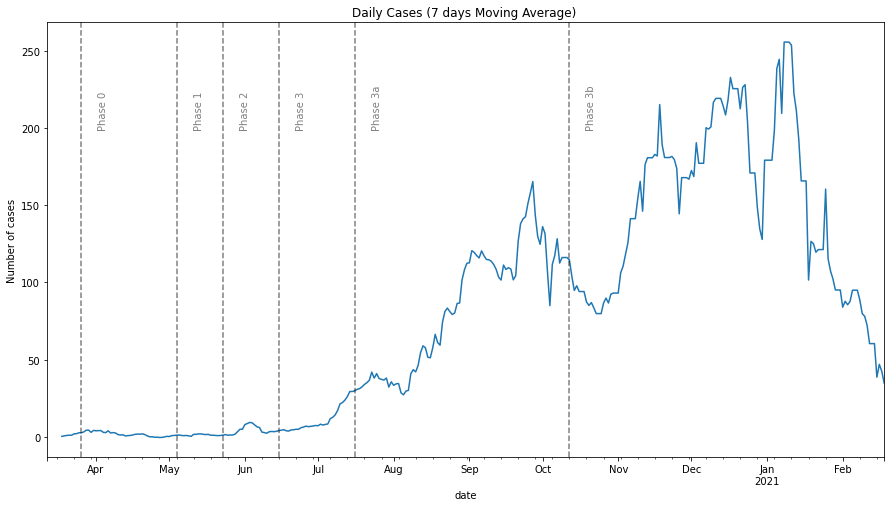

In [41]:

delta = timedelta(days=7)

us_counties.mean_daily_cases.plot(figsize=(15, 8))
plt.title("Daily Cases (7 days Moving Average) ")
plt.ylabel("Number of cases")
for i, phase in dates_df[['date', 'phase']].iterrows():
    plt.axvline(phase['date'], color='k', linestyle='--', alpha=0.5)
    plt.text(phase['date'] + delta, 200, 'Phase ' + phase['phase'], rotation=90, alpha = 0.5)

In [42]:
us_counties.dropna(inplace=True)

In [43]:
us_counties.index.min()

Timestamp('2020-03-18 00:00:00')

In [44]:
num_days = us_counties.index.max() - us_counties.index.min()
num_days = num_days.days + 1

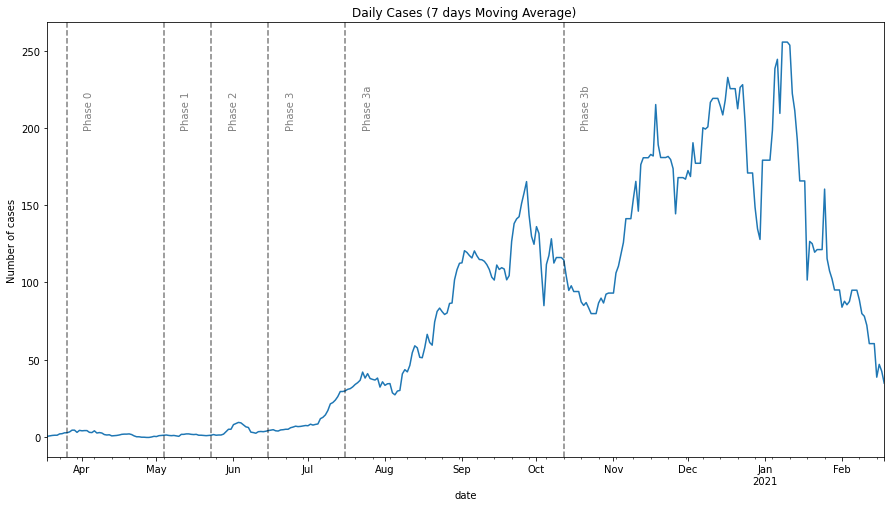

In [45]:
us_counties.mean_daily_cases.plot(figsize=(15, 8))
plt.title("Daily Cases (7 days Moving Average) ")
plt.ylabel("Number of cases")
for i, phase in dates_df[['date', 'phase']].iterrows():
    plt.axvline(phase['date'], color='k', linestyle='--', alpha=0.5)
    plt.text(phase['date'] + delta, 200, 'Phase ' + phase['phase'], rotation=90, alpha = 0.5)

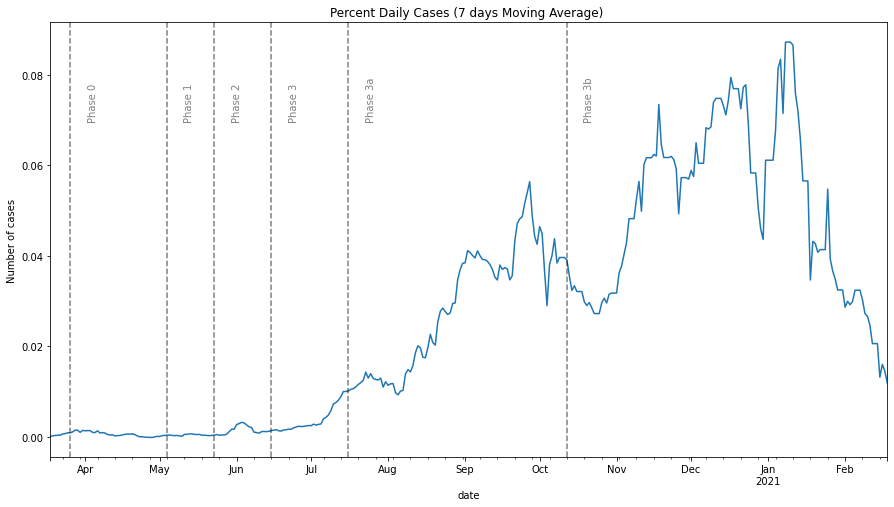

In [46]:
greene_population = 293086

us_counties['percent_daily_cases'] = np.round(100 * us_counties.mean_daily_cases/greene_population, 5)
us_counties['percent_daily_cases'].plot(figsize=(15, 8))
plt.title("Percent Daily Cases (7 days Moving Average) ")
plt.ylabel("Number of cases")
for i, phase in dates_df[['date', 'phase']].iterrows():
    plt.axvline(phase['date'], color='k', linestyle='--', alpha=0.5)
    plt.text(phase['date'] + delta, 0.07, 'Phase ' + phase['phase'], rotation=90, alpha = 0.5)

## Parameters settings

Até então obtive os melhores resultados de simulação com essas políticas de reabertura abaixo. Nelas estou considerando que ocupação máxima parcial ( 25 ou 50%) ainda é lockdown.  

In [47]:
# Original parameters extracted from Springfield - Greene reopening guidelines
listeners = [
    ["AddPolicy", SocialPolicy.LOCKDOWN_RETAIL, 1],
    ["AddPolicy", SocialPolicy.LOCKDOWN_FACTORY, 1],
    ["AddPolicy", SocialPolicy.LOCKDOWN_OFFICE, 1],
    ["AddPolicy", SocialPolicy.LOCKDOWN_ELEMENTARY_SCHOOL, 1],
    ["AddPolicy", SocialPolicy.LOCKDOWN_MIDDLE_SCHOOL, 1],
    ["AddPolicy", SocialPolicy.LOCKDOWN_HIGH_SCHOOL, 1],
    ["RemovePolicy", SocialPolicy.LOCKDOWN_ELEMENTARY_SCHOOL, 95],
    ["RemovePolicy", SocialPolicy.LOCKDOWN_MIDDLE_SCHOOL, 95],
    ["RemovePolicy", SocialPolicy.LOCKDOWN_HIGH_SCHOOL, 95],
    ["RemovePolicy", SocialPolicy.LOCKDOWN_RETAIL, 214],
    ["RemovePolicy", SocialPolicy.LOCKDOWN_FACTORY, 214],
    ["RemovePolicy", SocialPolicy.LOCKDOWN_OFFICE, 214],
]

I've been trying to replicate results from a real world case

I've collected and processed the data from the county of Greene (in Missouri, US). And extracted from their documents a few reopening guidelines/policies that I tried to replicate in our experiment. 

I haven't gotten nive results up until now, it feels like I have little control over the policies (e.g.: they often reopen stuff with a 25% occupancy limit, which I couldn't replicate). So I'm iterating over the policies and parameters of the simulation to get better results.

Analysis: I might be simulating with too little data... By the time we get to the period in which the real world cases would be rising faster, there's not a lot of susceptible agents in the simulation. 

By the way, since I noticed that the susceptible agents are strictly decreasing, should we take into account that people can be infected more than once and start making them susceptible again? 

In [50]:
listeners = [
    ["AddPolicy", SocialPolicy.LOCKDOWN_RETAIL, 0],
    ["AddPolicy", SocialPolicy.LOCKDOWN_FACTORY, 0],
    ["AddPolicy", SocialPolicy.LOCKDOWN_OFFICE, 0],
    ["AddPolicy", SocialPolicy.LOCKDOWN_ELEMENTARY_SCHOOL, 0],
    ["AddPolicy", SocialPolicy.LOCKDOWN_MIDDLE_SCHOOL, 0],
    ["AddPolicy", SocialPolicy.LOCKDOWN_HIGH_SCHOOL, 0],
    ["AddPolicy", SocialPolicy.LOCKDOWN_ALL, 0],
    ["RemovePolicy", SocialPolicy.LOCKDOWN_ALL, 95],
    ["RemovePolicy", SocialPolicy.LOCKDOWN_RETAIL, 95],
    ["RemovePolicy", SocialPolicy.LOCKDOWN_FACTORY, 95],
    ["RemovePolicy", SocialPolicy.LOCKDOWN_OFFICE, 214],
    ["RemovePolicy", SocialPolicy.LOCKDOWN_ELEMENTARY_SCHOOL, 214],
    ["RemovePolicy", SocialPolicy.LOCKDOWN_MIDDLE_SCHOOL, 214],
    ["RemovePolicy", SocialPolicy.LOCKDOWN_HIGH_SCHOOL, 214],
]

In [59]:
common_parameters = SimulationParameters(
    mask_user_rate = 0.9, # 0.0,
    mask_efficacy = 0.6, #0.0,
    imune_rate = 0.01,
    initial_infection_rate = 0.001,
    hospitalization_capacity = 0.05,
    latency_period_shape = 3,
    latency_period_scale = 1, 
    incubation_period_shape = 6,
    incubation_period_scale = 1, 
    mild_period_duration_shape = 14,
    mild_period_duration_scale = 1,
    hospitalization_period_duration_shape = 12,
    hospitalization_period_duration_scale = 1,
    symptomatic_isolation_rate = 0.0,
    asymptomatic_contagion_probability = 0.1,
#    asymptomatic_contagion_probability = 0.05,
#     risk_tolerance_mean = 0.7,
    risk_tolerance_mean = 0.4,
    risk_tolerance_stdev = 0.2,
    herding_behavior_mean = 0.7,
#    herding_behavior_mean = 0.1,
    herding_behavior_stdev = 0.2,
    allowed_restaurant_capacity = 0.25, #1.0, # valid values: {1.0, 0.50, 0.25}
    spreading_rate = normal_ci(2.41, 3.90, 20)
#    spreading_rate = normal_ci(0.5, 1.5, 20)
)

sc = 10

population_size = 1500
simulation_cycles = num_days # days
seed = 31415
np.random.seed(seed)

params = copy.deepcopy(common_parameters)

Save these seeds if you want to rerun a scenario
[9675]
Average similarity between family members is 0.9999351333031227 at temperature -1
Average similarity between family and home is 0.9999328035650535 at temperature -1
Average similarity between students and their classroom is 0.9999081384327237 at temperature -1
Average classroom occupancy is 6.185714285714286 and number classrooms is 70
Average similarity between workers is 0.9999298626074015 at temperature -1
Average office occupancy is 3.88 and number offices is 250
Average friend similarity for adults: 0.999917608080943 for kids: 0.9999114030526758
home_districts
[
Home (0,0) district with 30 Buildings
HomogeneousBuilding: 20 units (each with capacity for 5 people.) 19 allocated units with a total of 60 people.
HomogeneousBuilding: 20 units (each with capacity for 5 people.) 20 allocated units with a total of 56 people.
HomogeneousBuilding: 20 units (each with capacity for 5 people.) 19 allocated units with a total of 54 people.

avg restaurant similarity 0.9998130741443441
avg restaurant similarity 0.9998232790846237
avg restaurant similarity 0.9998527917727611
avg restaurant similarity 0.9998141056935427
avg restaurant similarity 0.9998163268540367
avg restaurant similarity 0.9997854133132849
avg restaurant similarity 0.9998259386287339
avg restaurant similarity 0.9998326376044928
avg restaurant similarity 0.9998249375529668
avg restaurant similarity 0.9998196817805569
avg restaurant similarity 0.9997937213245449
avg restaurant similarity 0.9998215204210192
avg restaurant similarity 0.9998106525928225
avg restaurant similarity 0.9998246012489943
avg restaurant similarity 0.9998449279835159
avg restaurant similarity 0.9998274480280116
avg restaurant similarity 0.9997971993334546
avg restaurant similarity 0.9998420344650724
avg restaurant similarity 0.9997836684873804
avg restaurant similarity 0.9998239736197475
avg restaurant similarity 0.9998466220096763
avg restaurant similarity 0.9998069703030398
avg restau

avg restaurant similarity 0.9998381959543928
avg restaurant similarity 0.9998270518035238
avg restaurant similarity 0.9998278308194597
avg restaurant similarity 0.9998360647651962
avg restaurant similarity 0.9998724070232949
avg restaurant similarity 0.9998007321461952
avg restaurant similarity 0.9998354275886381
avg restaurant similarity 0.99979453795384
avg restaurant similarity 0.999812341749028
avg restaurant similarity 0.9998260230104581
avg restaurant similarity 0.9997982418060131
avg restaurant similarity 0.9998566143133094
avg restaurant similarity 0.9998131977241815
avg restaurant similarity 0.9998390775920626
avg restaurant similarity 0.9998735165621637
avg restaurant similarity 0.9998389225404543
avg restaurant similarity 0.9998456845793356
avg restaurant similarity 0.9998509351936352
avg restaurant similarity 0.9998348500614647
avg restaurant similarity 0.9998049766877062
avg restaurant similarity 0.9998307294165902
avg restaurant similarity 0.9998580166909288
avg restauran

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


using average of time series:
stats on susceptible:
data: [0.7153234714003945]
min:
0.7153234714003945
max:
0.7153234714003945
std:
0.0
mean:
0.7153234714003945
median:
0.7153234714003945
95% confidence interval for the mean:
(nan,nan)
using average of time series:
stats on infected:
data: [0.051408284023668635]
min:
0.051408284023668635
max:
0.051408284023668635
std:
0.0
mean:
0.051408284023668635
median:
0.051408284023668635
95% confidence interval for the mean:
(nan,nan)
using average of time series:
stats on recovered:
data: [0.2180591715976331]
min:
0.2180591715976331
max:
0.2180591715976331
std:
0.0
mean:
0.2180591715976331
median:
0.2180591715976331
95% confidence interval for the mean:
(nan,nan)
using average of time series:
stats on hospitalization:
data: [0.008504930966469428]
min:
0.008504930966469428
max:
0.008504930966469428
std:
0.0
mean:
0.008504930966469428
median:
0.008504930966469428
95% confidence interval for the mean:
(nan,nan)
using average of time series:
stats o

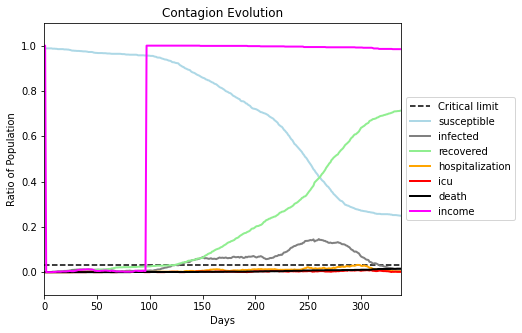

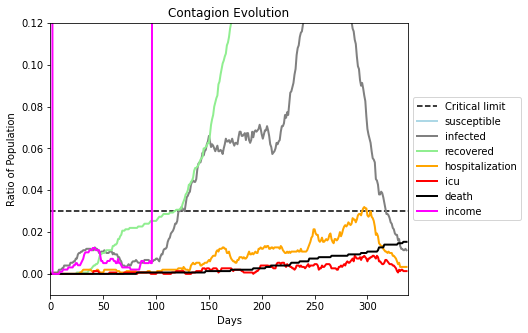

In [60]:
import logging
def setLevel(level):
    logger1 = logging.getLogger()
    logger1.setLevel(level)

seeds = [9675]
setLevel(logging.CRITICAL)
statistics, avg,  last,  peak = multiple_runs(params,
                              population_size,
                              simulation_cycles,
                              seeds = seeds,
                              fname = "ramon", 
                              do_print = True, 
                              desired_stats = ["susceptible", "infected", "recovered", "hospitalization", "icu", "death", "income"],
                              listeners = listeners)

In [61]:
simulation_df = pd.DataFrame({'susceptible': statistics.susceptible,
    'infected': statistics.infected,
    'hospitalization': statistics.hospitalization,
    'recovered': statistics.recovered,
    'death': statistics.death,
    'icu': statistics.icu})

In [62]:
simulation_df.index = us_counties.index

In [63]:
dates_df

,date,phase,num_days
0,2020-03-26,0,14
1,2020-05-04,1,53
2,2020-05-23,2,72
3,2020-06-15,3,95
4,2020-07-16,3a,126
5,2020-10-12,3b,214


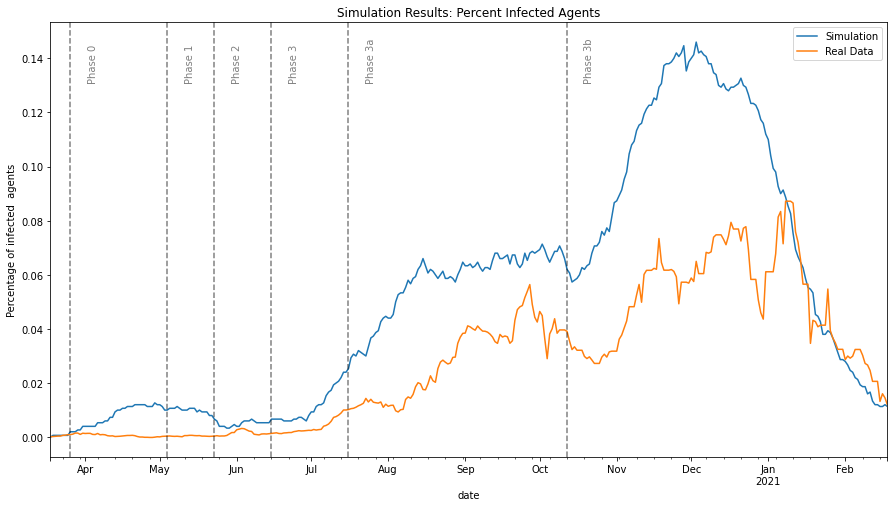

In [64]:
simulation_df['infected'].plot(figsize=(15, 8))
us_counties['percent_daily_cases'].plot()
plt.title("Simulation Results: Percent Infected Agents")
plt.legend(['Simulation', 'Real Data'])
plt.ylabel("Percentage of infected  agents")
for i, phase in dates_df[['date', 'phase']].iterrows():
    plt.axvline(phase['date'], color='k', linestyle='--', alpha=0.5)
    plt.text(phase['date'] + delta, 0.9*np.max(simulation_df['infected']), 'Phase ' + phase['phase'], rotation=90, alpha = 0.5)

___

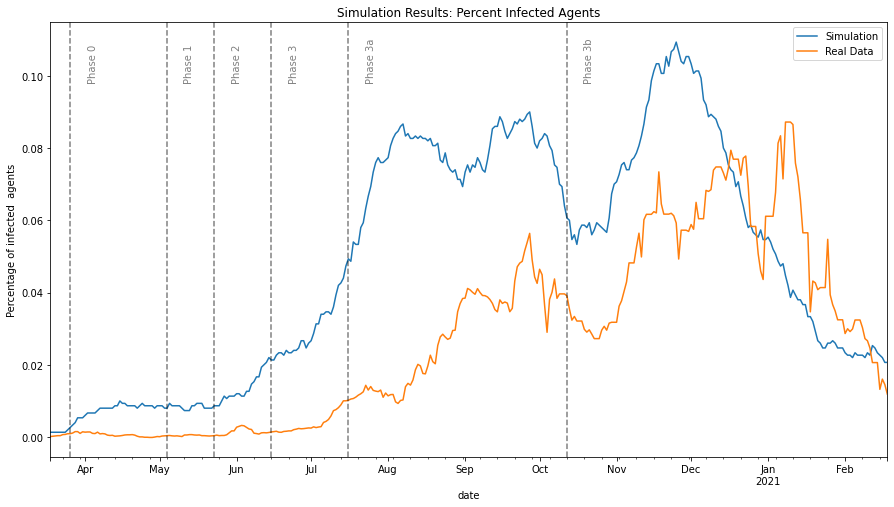

In [58]:
simulation_df['infected'].plot(figsize=(15, 8))
us_counties['percent_daily_cases'].plot()
plt.title("Simulation Results: Percent Infected Agents")
plt.legend(['Simulation', 'Real Data'])
plt.ylabel("Percentage of infected  agents")
for i, phase in dates_df[['date', 'phase']].iterrows():
    plt.axvline(phase['date'], color='k', linestyle='--', alpha=0.5)
    plt.text(phase['date'] + delta, 0.9*np.max(simulation_df['infected']), 'Phase ' + phase['phase'], rotation=90, alpha = 0.5)

____

In [ ]:
listeners = [
    ["AddPolicy", SocialPolicy.LOCKDOWN_ALL, 1],
    ["RemovePolicy", SocialPolicy.LOCKDOWN_RETAIL, 95],
    ["RemovePolicy", SocialPolicy.LOCKDOWN_FACTORY, 95],
    ["RemovePolicy", SocialPolicy.LOCKDOWN_ELEMENTARY_SCHOOL, 95],
    ["RemovePolicy", SocialPolicy.LOCKDOWN_MIDDLE_SCHOOL, 95],
    ["RemovePolicy", SocialPolicy.LOCKDOWN_HIGH_SCHOOL, 95],
    ["RemovePolicy", SocialPolicy.LOCKDOWN_ALL, 214],
]

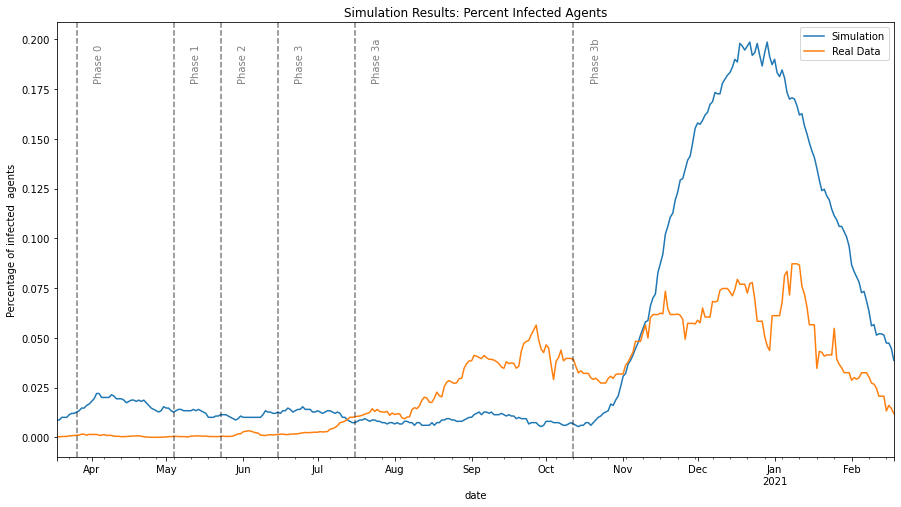

In [91]:
simulation_df['infected'].plot(figsize=(15, 8))
us_counties['percent_daily_cases'].plot()
plt.title("Simulation Results: Percent Infected Agents")
plt.legend(['Simulation', 'Real Data'])
plt.ylabel("Percentage of infected  agents")
for i, phase in dates_df[['date', 'phase']].iterrows():
    plt.axvline(phase['date'], color='k', linestyle='--', alpha=0.5)
    plt.text(phase['date'] + delta, 0.9*np.max(simulation_df['infected']), 'Phase ' + phase['phase'], rotation=90, alpha = 0.5)

In [98]:
4/greene_population

1.3647871273278151e-05

In [93]:
us_counties.head()

,cases,deaths,daily_cases,mean_daily_cases,percent_daily_cases
date,,,,,
2020-03-18,4,0.0,0,0.428571,0.00015
2020-03-19,6,0.0,2,0.714286,0.00024
2020-03-20,8,0.0,2,1.000000,0.00034
2020-03-21,10,0.0,2,1.142857,0.00039
2020-03-22,10,0.0,0,1.142857,0.00039


____

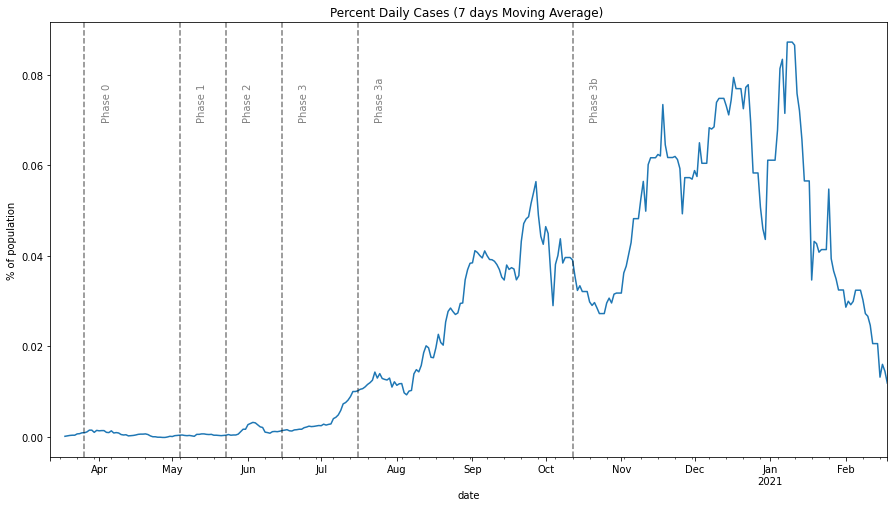

In [79]:
us_counties['percent_daily_cases'].plot(figsize=(15, 8))
plt.title("Percent Daily Cases (7 days Moving Average) ")
plt.ylabel("% of population")
for i, phase in dates_df[['date', 'phase']].iterrows():
    plt.axvline(phase['date'], color='k', linestyle='--', alpha=0.5)
    plt.text(phase['date'] + delta, 0.07, 'Phase ' + phase['phase'], rotation=90, alpha = 0.5)

In [77]:
simulation_df.head()

,susceptible,infected,hospitalization,recovered,death,icu
0,0.979333,0.008333,0.0,0.0,0.0,0.0
1,0.978667,0.009000,0.0,0.0,0.0,0.0
2,0.978000,0.009667,0.0,0.0,0.0,0.0
3,0.978000,0.009667,0.0,0.0,0.0,0.0
4,0.976667,0.011000,0.0,0.0,0.0,0.0


Pros dados de casos de covid que obtive do NYTimes (que batem com os do site de Springfield), fiz esse gráfico abaixo. Considerei a média móvel (7 dias) do número de casos e dividi pela população total de Greene (293,086). Assim tenho número de infectados de acordo com percentual da  população, o que ajuda porque até então estou rodando simulações com 1000 agentes pra ser mais rápido já que toda hora mudo algo. Ainda assim acho que a população real é grande demais pra simulação, então seria melhor manter tudo em termos relativos mesmo.

Outra coisa que fiz foi colocar linhas tracejadas em cada data de mudança de fase de reabertura pra ter ideia de quais políticas mais influenciaram a curva e quanto. 

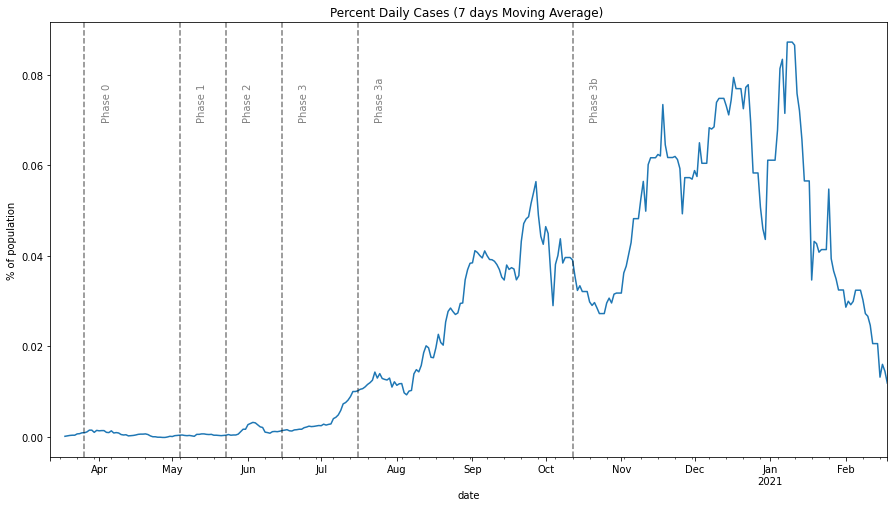

In [94]:
us_counties['percent_daily_cases'].plot(figsize=(15, 8))
plt.title("Percent Daily Cases (7 days Moving Average) ")
plt.ylabel("% of population")
for i, phase in dates_df[['date', 'phase']].iterrows():
    plt.axvline(phase['date'], color='k', linestyle='--', alpha=0.5)
    plt.text(phase['date'] + delta, 0.07, 'Phase ' + phase['phase'], rotation=90, alpha = 0.5)

2020-03-26 00:00:00
2020-05-04 00:00:00
2020-05-23 00:00:00
2020-06-15 00:00:00
2020-07-16 00:00:00
2020-10-12 00:00:00


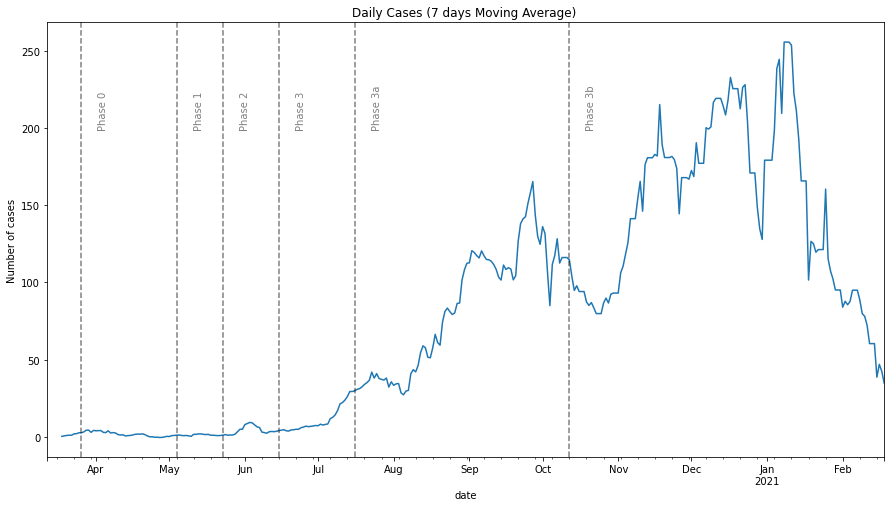

In [106]:
us_counties.mean_daily_cases.plot(figsize=(15, 8))
plt.title("Daily Cases (7 days Moving Average) ")
plt.ylabel("Number of cases")
for i, phase in dates_df[[0, 'phase']].iterrows():
    print(phase[0])
    plt.axvline(phase[0], color='k', linestyle='--', alpha=0.5)
    plt.text(phase[0] + delta, 200, 'Phase ' + phase['phase'], rotation=90, alpha = 0.5)

___

# Default parameters. Unless explicitly overriden, these values are used in all scenarios
common_parameters = SimulationParameters(
    mask_user_rate = 0.0,
    mask_efficacy = 0.0,
    imune_rate = 0.01,
    initial_infection_rate = 0.01,
    hospitalization_capacity = 0.05,
    latency_period_shape = 3,
    latency_period_scale = 1, 
    incubation_period_shape = 6,
    incubation_period_scale = 1, 
    mild_period_duration_shape = 14,
    mild_period_duration_scale = 1,
    hospitalization_period_duration_shape = 12,
    hospitalization_period_duration_scale = 1,
    symptomatic_isolation_rate = 0.0,
    asymptomatic_contagion_probability = 0.1,
    risk_tolerance_mean = 0.7,
    risk_tolerance_stdev = 0.2,
    herding_behavior_mean = 0.7,
    herding_behavior_stdev = 0.2,
    allowed_restaurant_capacity = 1.0, # valid values: {1.0, 0.50, 0.25}
    spreading_rate = normal_ci(2.41, 3.90, 20)
)

# Simulation setup
population_size = 30086

simulation_cycles = 100 # days
seed = 31415
np.random.seed(seed)
scenario = {}

sc = 3
params = copy.deepcopy(common_parameters)
params.params['social_policies'] = [
    SocialPolicy.LOCKDOWN_OFFICE,
    SocialPolicy.LOCKDOWN_FACTORY,
    SocialPolicy.LOCKDOWN_RETAIL,
    SocialPolicy.LOCKDOWN_ELEMENTARY_SCHOOL,
    SocialPolicy.LOCKDOWN_MIDDLE_SCHOOL,
    SocialPolicy.LOCKDOWN_HIGH_SCHOOL,
    SocialPolicy.SOCIAL_DISTANCING
]

set_parameters(params)
model = CovidModel()
np.random.seed(seed)
setup_city_layout(model, population_size)
model.add_listener(RemovePolicy(model, SocialPolicy.LOCKDOWN_ELEMENTARY_SCHOOL, 30))
model.add_listener(RemovePolicy(model, SocialPolicy.LOCKDOWN_MIDDLE_SCHOOL, 60))
model.add_listener(RemovePolicy(model, SocialPolicy.LOCKDOWN_HIGH_SCHOOL, 90))

model.reset_randomizer(seed)
statistics = BasicStatistics(model)
model.add_listener(statistics)
for i in range(simulation_cycles):
    model.step()
statistics.export_chart("scenario" + str(sc) + ".png")
statistics.export_csv("scenario" + str(sc) + ".csv")